<a href="https://colab.research.google.com/github/AbhiJ2706/generate-images-AI/blob/master/Part_2_generate_handwritten_digits_from_noise_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Networks (part 2)- generating a picture of a digit from noise**

This neural network can generate pictures of the number 8, given scranbled nonsense (noise) as input. The input would look like nothing in particular to a human, but the output is a picture of the number 8.

*How it works*

This form of neural network is called a GAN-  a Gain-Adversial Network.

The neural network consists of 2 (sub)networks- the generator and the discriminator. A given loop through the network consists of this: 
- The generator (untrained) tries to create pictures of the number 8 (it creates noise instead)
- The discriminator is trained to recognize the number 8 on a very small batch of images (128 images of the number 8 and 128 pictures of noise created by the untrained generator). 
- The discriminator then becomes untrainable
- The generator is then trained to create pictures of the number 8 given noise. The discriminator examines each output the generator creates to check if it indeed looks like the number 8 or not. 

This process is repeated 1050 times to generate the output. 

*Data formatting*

At the beginning of this project I was training the discriminator once on 16000 data points, and then the generator once on 10000 data points. This did no return good results

This barely gets the shape of an 8, but most of it is really just noise. Formatting the data to just use 128 images of 8 and 128 noise and then training it many more times gave better results.

*Epoch Number, Dropout and Learning Rate*

The number of Epochs is the amount of times you repeat the training process. In the original network (before the data was formatted), the discriminator ran 10 epochs once and then the generator ran 75 epochs, once. Now, both run 1050 in in sequence (so the discriminator runs 1 epoch then the generator, and this is repeated 1050 times). The number 1050 was chosen by testing various numbers of epochs on the data and seeing how close the result was.

Dropout is a neural network layer which sets a random fraction of the inputs to the next layer to 0. This is important because it greatly increases the ability for the network to learn seeing as it has less values to concern itself with. Adding a few dropouts to the generator and discriminator greatly increased their ability to recognize shapes. 

The learning rate is part of a neural network optimizer, an algorithm that makes learning easier on the network. One of its changeable parameters is called the learning rate. Changing this changes the amount by which the weights of the network are altered. Having a learning rate that's too high or low can result in unusable output.

Configuring these parameters correctly can result in good output.

You can run the code below to see this in action!

Abhi



In [11]:
#CHANGE THIS TO CHANGE THE DIGIT BEING DRAWN
n = 8

In [12]:
#import libraries
#machine learning libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
#other libraries
import numpy as np
import random
import collections
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8] #configuring graphs 

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data() #getting train data

#making train data and test data neural network friendly (converts images from 28x28 to 1x784)
train_images = train_images.reshape((train_images.shape[0], 784)).astype('float32')
train_images = train_images / 255

test_images = test_images.reshape((test_images.shape[0], 784)).astype('float32')
test_images = test_images / 255

#Getting pictures of the number 8
realData = []

for i in range(len(train_images)):
  if train_labels[i] == n and len(realData) < 128:
    realData.append(train_images[i])

realAnswers = [n for i in range(len(realData))]
realData = np.array(realData, dtype="float")
realAnswers = np.array(realAnswers, dtype="float")

print(realData.shape, realAnswers.shape)

print(train_images[61].shape)

#Generator network
model = keras.Sequential([
    keras.layers.Dense(256,input_dim=784, activation=tf.nn.relu), #input
    #hidden layers
    keras.layers.Dropout(0.2),
    keras.layers.Dense(432),
    keras.layers.Dropout(0.2),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(1024, activation=tf.nn.leaky_relu),
    keras.layers.Dropout(0.2),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(432),
    keras.layers.Dropout(0.2),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dense(784, activation=tf.nn.leaky_relu) #output layer
])

#discriminator network
model2 = keras.Sequential([
    keras.layers.Dense(784, input_dim=784, activation = tf.nn.tanh), #input
    #hidden layers
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation=tf.nn.tanh),
    keras.layers.Dense(60, activation=tf.nn.tanh),
    keras.layers.Dense(30, activation=tf.nn.tanh),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax) #output
])

#compiling models with regular optimizers
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=["mean_squared_error", "accuracy"])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

adam = Adam(lr=0.000327, beta_1=0.5) #custom optimizer

#Creating the GAN by joing the generator and discriminator
model2.trainable = False
ganInput = Input(shape=(784,)) #creating input layer for GAN
x = model(ganInput) #giving this input layer to generator
ganOutput = model2(x) #giving the generator with the new input layer to the discriminator
gan = Model(inputs=ganInput, outputs=ganOutput) #creating combined model now that both networks are linked
gan.compile(loss='sparse_categorical_crossentropy', optimizer=adam) #compiling combined model with custom optimizer

#training network
for i in range(1050): #number decided on by testing

  print("Epoch", i)
  train_noise = np.array([np.random.normal(0,1,size=(784)) for i in range(128)], dtype="float") #creating noise for the generator to predict on
  refined_noise = model.predict(train_noise) #more noise created by generator

  print(refined_noise.shape, realData.shape)
  X = np.concatenate((realData, refined_noise)) #combining 8s and generated noise
  y = np.concatenate((realAnswers, np.array([0 for i in range(128)]))) #creating labels

  model2.trainable = True
  model2.train_on_batch(X, y) #training the discriminator on the created data

  #creating more training data for the combined network
  X2 = np.array([np.random.normal(0,1,size=(784)) for i in range(256)], dtype="float")
  y2 = np.array([n for i in range(256)])

  model2.trainable = False #making sure discriminator cannot be trained (we assume it will always be correct now)
  gan.train_on_batch(X2, y2) #training the combined network on the training data (only adjusts the generator though)


(128, 784) (128,)
(784,)
Epoch 0
(128, 784) (128, 784)
Epoch 1
(128, 784) (128, 784)
Epoch 2
(128, 784) (128, 784)
Epoch 3
(128, 784) (128, 784)
Epoch 4
(128, 784) (128, 784)
Epoch 5
(128, 784) (128, 784)
Epoch 6
(128, 784) (128, 784)
Epoch 7
(128, 784) (128, 784)
Epoch 8
(128, 784) (128, 784)
Epoch 9
(128, 784) (128, 784)
Epoch 10
(128, 784) (128, 784)
Epoch 11
(128, 784) (128, 784)
Epoch 12
(128, 784) (128, 784)
Epoch 13
(128, 784) (128, 784)


KeyboardInterrupt: ignored

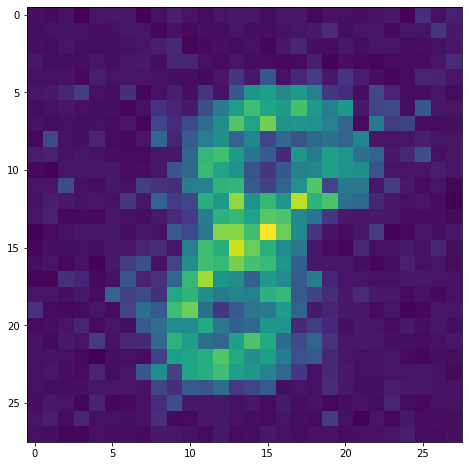

In [ ]:
'''
This piece of code makes the generator create 8s given noise (it's already trained) and dispays the result 
'''

noise = np.random.normal(0, 1, size=[10000, 784])
generatedImages = model.predict(noise)

generatedImages = generatedImages.reshape(10000, 28, 28)

plt.imshow(generatedImages[0])
plt.show()